# <center> ДЗ 31. Прогноз просрочки кредита заемщиком с использованием PyTorch</center>

### Татур А.А.
### V.0.1
### 20.03.2022
### Цель: Выполнить задачу бинарной классификации с использованием Torch

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.metrics import AUC

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

MM  = MinMaxScaler(feature_range=(0,1))

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import ReLU, Linear, BatchNorm1d, Dropout, Sequential, Module, BCEWithLogitsLoss, Sigmoid
import time
import gc

In [2]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None

if tpu:
    policyConfig = 'mixed_bfloat16'
else: 
    policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)
'''

"\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    policyConfig = 'mixed_bfloat16'\nelse: \n    policyConfig = 'mixed_float16'\npolicy = tf.keras.mixed_precision.Policy(policyConfig)\ntf.keras.mixed_precision.set_global_policy(policy)\n"

In [4]:
#
#tf.tpu.XLAOptions(
#    use_spmd_for_xla_partitioning=True, enable_xla_dynamic_padder=True
#)

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [5]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [6]:
df = pd.read_csv('cs-training.csv', index_col=0)
#df.dropna(axis=0, inplace=True)

In [7]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [8]:
list(set(df._get_numeric_data().columns)-set(df.columns))

[]

### I. Эксплоративный анализ. Проверяем значения по отдельным колонкам

##### 01. Проверим значения по колонке 'age'

In [9]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.age.value_counts()).sort_index()

,age
0,1
21,183
22,434
23,641
24,816
25,953
26,1193
27,1338
28,1560
29,1702


##### Удалим ту строку, где возраст равен '0', т.к. этот случай единичен.

In [10]:
pd.set_option('display.max_rows', 10)
df.loc[df.age==0].index[0] # вычисляем индекс строки, в которой возраст равен '0'
df.drop(df.loc[df.age==0].index[0], axis=0, inplace=True)

##### 02. Проверим значения по колонке 'NumberOfTime30-59DaysPastDueNotWorse'

In [11]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()).sort_index()

,NumberOfTime30-59DaysPastDueNotWorse
0,126018
1,16032
2,4598
3,1754
4,747
5,342
6,140
7,54
8,25
9,12


##### Вывод: Поскольку значения '96' и "98' в колонке 'NumberOfTime30-59DaysPastDueNotWorse' очень сильно отличаются от других. Можно предположить, что на самом деле это значения '06' и '08'. Поэтом поменяем их значения на '6' и '8' соответственно

In [12]:
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==96, 'NumberOfTime30-59DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==98, 'NumberOfTime30-59DaysPastDueNotWorse']=8

##### 03. Проанализируем колонки 'DebtRatio' и 'MonthlyIncome' вместе (т.к. два параметра тесно связаны). Поскольку в колонке 'MonthlyIncome' есть NaN Значения, то заменим их на -1 чтобы можно было визуализировать все на графиках.

In [13]:
df.MonthlyIncome.fillna(-1, inplace=True)

<AxesSubplot: xlabel='MonthlyIncome', ylabel='DebtRatio'>

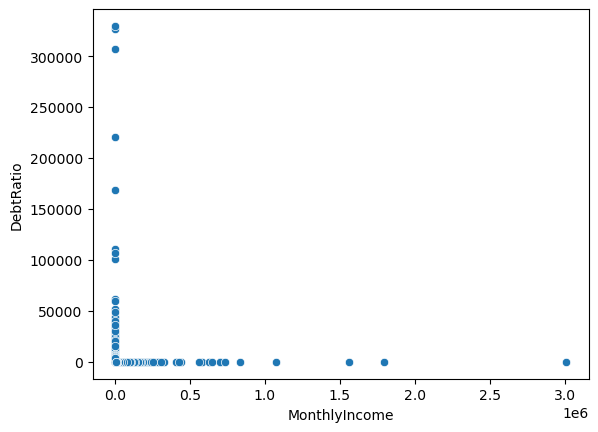

In [14]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df)

##### Построим график снова с ограничением по значению месячного дохода до 5

<AxesSubplot: xlabel='MonthlyIncome', ylabel='DebtRatio'>

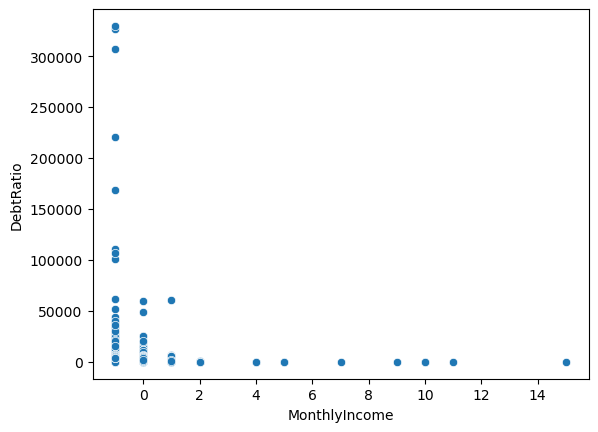

In [15]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df.loc[df.MonthlyIncome<20])

##### Посчитаем как распределяется DebtRatio в зависимости от дохода

In [16]:
pd.qcut(df.loc[df['MonthlyIncome']==-1, 'DebtRatio'],90, duplicates="drop").value_counts()

(-0.001, 1.0]           1827
(2.0, 5.0]               450
(7.0, 11.0]              417
(37.0, 44.0]             358
(22.0, 27.0]             353
(51.0, 60.0]             348
(31.0, 37.0]             347
(1761.0, 1816.0]         341
(297.0, 344.0]           338
(1006.0, 1056.0]         338
(81.0, 96.0]             337
(1353.0, 1398.0]         337
(598.333, 653.0]         336
(96.0, 113.0]            335
(1865.667, 1926.0]       335
(2038.667, 2105.0]       335
(168.0, 207.0]           335
(1446.0, 1493.0]         334
(2415.0, 2486.0]         334
(2817.333, 2910.0]       334
(1708.0, 1761.0]         334
(3010.0, 3114.0]         333
(1547.0, 1599.0]         332
(432.0, 473.0]           332
(653.0, 701.0]           332
(804.0, 858.0]           332
(1159.0, 1207.0]         332
(388.0, 432.0]           332
(2163.0, 2225.0]         332
(4166.667, 4416.0]       332
(1599.0, 1651.0]         331
(2352.0, 2415.0]         331
(2562.333, 2642.0]       331
(3463.333, 3604.0]       331
(5094.333, 558

##### Вывод: как видно из представленного графика и возможных значений DebtRatio - наиболее вероятно при N/A Значений имеется ввиду нулевой доход, т.к. DebtRatio значительно больше нуля в большинстве случаев, а такого не может быть, человеку не могут выдать кредитов больше, чем он может погасить. Значит наиболее оправданным подходом является: для тех случаев, где DebtRatio <1 заполнить N/A медианным значением по колонке, в остальных случаях присвоить значение 0.

In [17]:
df.loc[(df.MonthlyIncome==-1)&(df.DebtRatio<1), 'MonthlyIncome']=df.MonthlyIncome.median()
df.loc[df['MonthlyIncome']==-1, 'MonthlyIncome']=0

##### 04. Проверим значения по колонке 'NumberOfTimes90DaysLate'

In [18]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.NumberOfTimes90DaysLate.value_counts()).sort_index()

,NumberOfTimes90DaysLate
0,141661
1,5243
2,1555
3,667
4,291
5,131
6,80
7,38
8,21
9,19


##### Как и для 'NumberOfTime30-59DaysPastDueNotWorse' заменим и тут значения 96 и 98 на 6 и 8

In [19]:
df.loc[df['NumberOfTimes90DaysLate']==96, 'NumberOfTimes90DaysLate']=6
df.loc[df['NumberOfTimes90DaysLate']==98, 'NumberOfTimes90DaysLate']=8

##### 05 Для NumberOfTime60-89DaysPastDueNotWorse тоже самое. Замени 96 и 98 на 6 и 8

In [20]:
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==96, 'NumberOfTime60-89DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==98, 'NumberOfTime60-89DaysPastDueNotWorse']=8

##### 06. Проверим значения NumberOfDependents

In [21]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfDependents'].value_counts())

,NumberOfDependents
0.0,86902
1.0,26316
2.0,19521
3.0,9483
4.0,2862
5.0,746
6.0,158
7.0,51
8.0,24
10.0,5


In [22]:
pd.set_option('display.max_rows', 10)

##### Вывод: Заполним пропуски медианным значением

In [23]:
df.NumberOfDependents.fillna(df.NumberOfDependents.median(), inplace=True)

##### 07. Поищем дубликаты в сете

In [24]:
sum(df.duplicated())

768

##### Удалим дубликаты

In [25]:
df.drop(df.loc[df.duplicated()].index, axis=0, inplace=True)

### II. Визуализируем сет.

##### 01. Используя  seaborn.pairplot (sns) визуализируйте данные (Учитывая ресурсозатратность данного графика возьмем из исходного набора лишь часть случаев, при этом сохранив изначальную пропорцию возвратов и невозвратов)

In [26]:
df_short = pd.concat([df.loc[df.SeriousDlqin2yrs==0][:100], #100 первых случаев с возвратом кредита
                      df.loc[df.SeriousDlqin2yrs==1][:10]], #10 первых с невозвратом
                     axis=0)

In [27]:
#sns.pairplot(df_short,
#           hue="SeriousDlqin2yrs", 
#            diag_kind="hist",
#            corner=True)

##### 02. Используя sns.heatmap постройте корреляционную матрицу

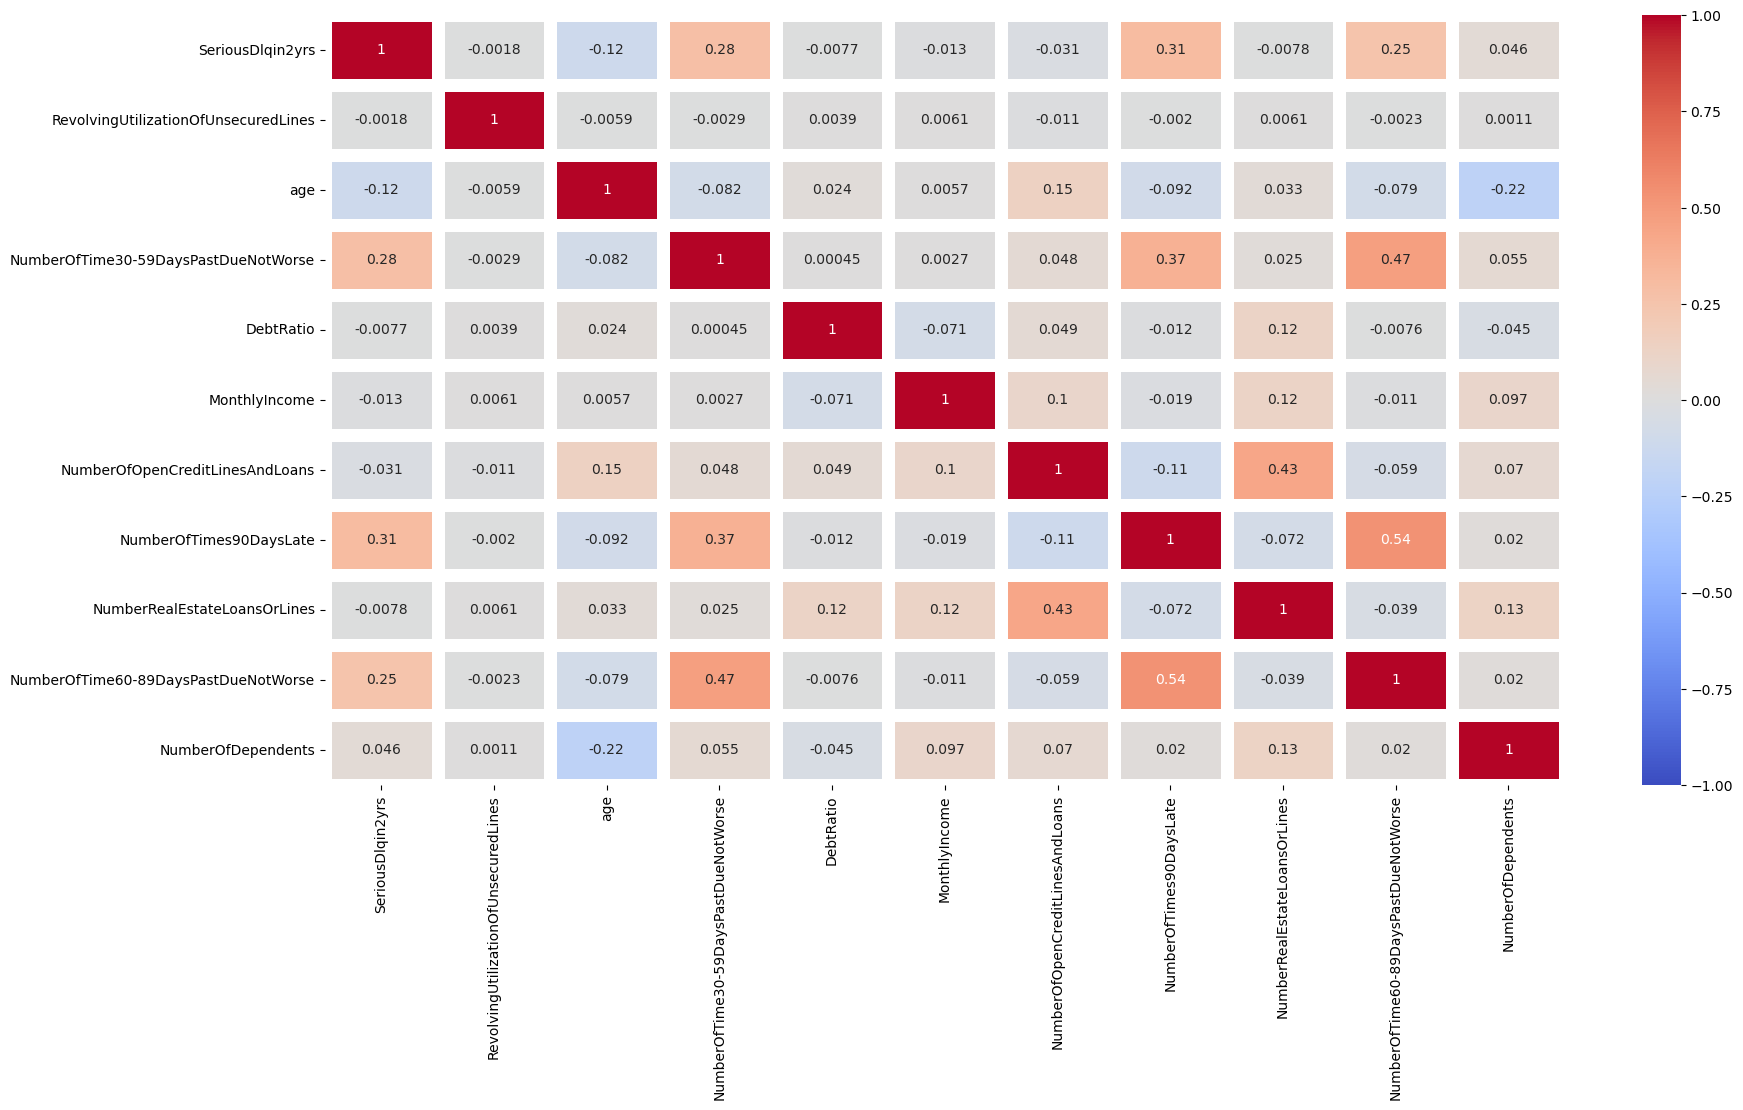

In [28]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),
            annot=True, 
            vmin=-1, vmax=1, 
            center= 0, 
            cmap= 'coolwarm', 
            linewidths=9, 
            linecolor='white', 
            cbar_kws= {'orientation': 'vertical'});

Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

Корелляцию можно видеть среди двух групп признаков:

* 1. __NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse__
* 2. __NumberOfOpenCreditLinesAndLoans и NumberRealEstateLoansOrLines__

Что может говорить о том, что:
1) Клиент, который просрочил выплату на 30-59 дней, просрочит ее и на 60-89 и на 90 дней.

2) Кредит на квартиру уже входит в признак "Число открытых кредитов"


__Однако, их удаление ни к чему хорошему не привело. Метрики обучения падают на 6-7 процентов. Поэтому колонки эти все оставил__

##### 03. Визуализация связи дохода и невозвратов.

<AxesSubplot: xlabel='MonthlyIncome', ylabel='count'>

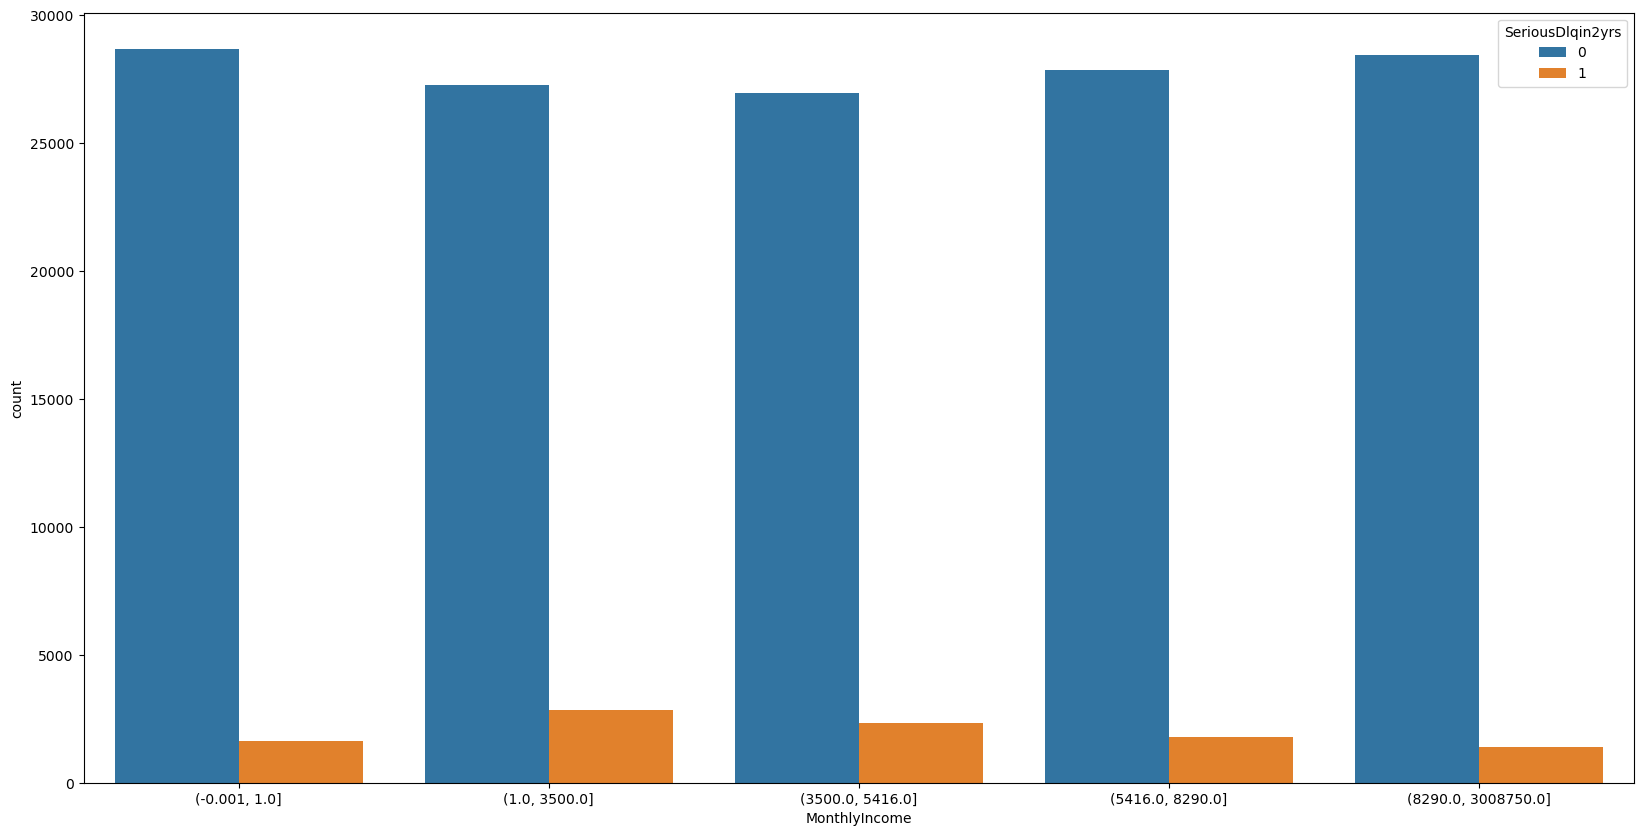

In [29]:
income_binned = income_binned = pd.qcut (df.MonthlyIncome, 5, duplicates='drop')

plt.figure(figsize=(20,10))
sns.countplot (x=income_binned, hue=df.SeriousDlqin2yrs)

#### Вывод: Данный график отражает интересную связь. Те люди, которые имеют в настоящий момент фактически нулевой доход (вероятно в результате потери работы) имеют меньшее количество невозвратов, нежели те, кто хронически мало зарабатывает. Далее количество невозвратов падает по мере роста доходов

### III. __Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

#### 01. Оценим количество кредитов по количеству лиц на иждивении

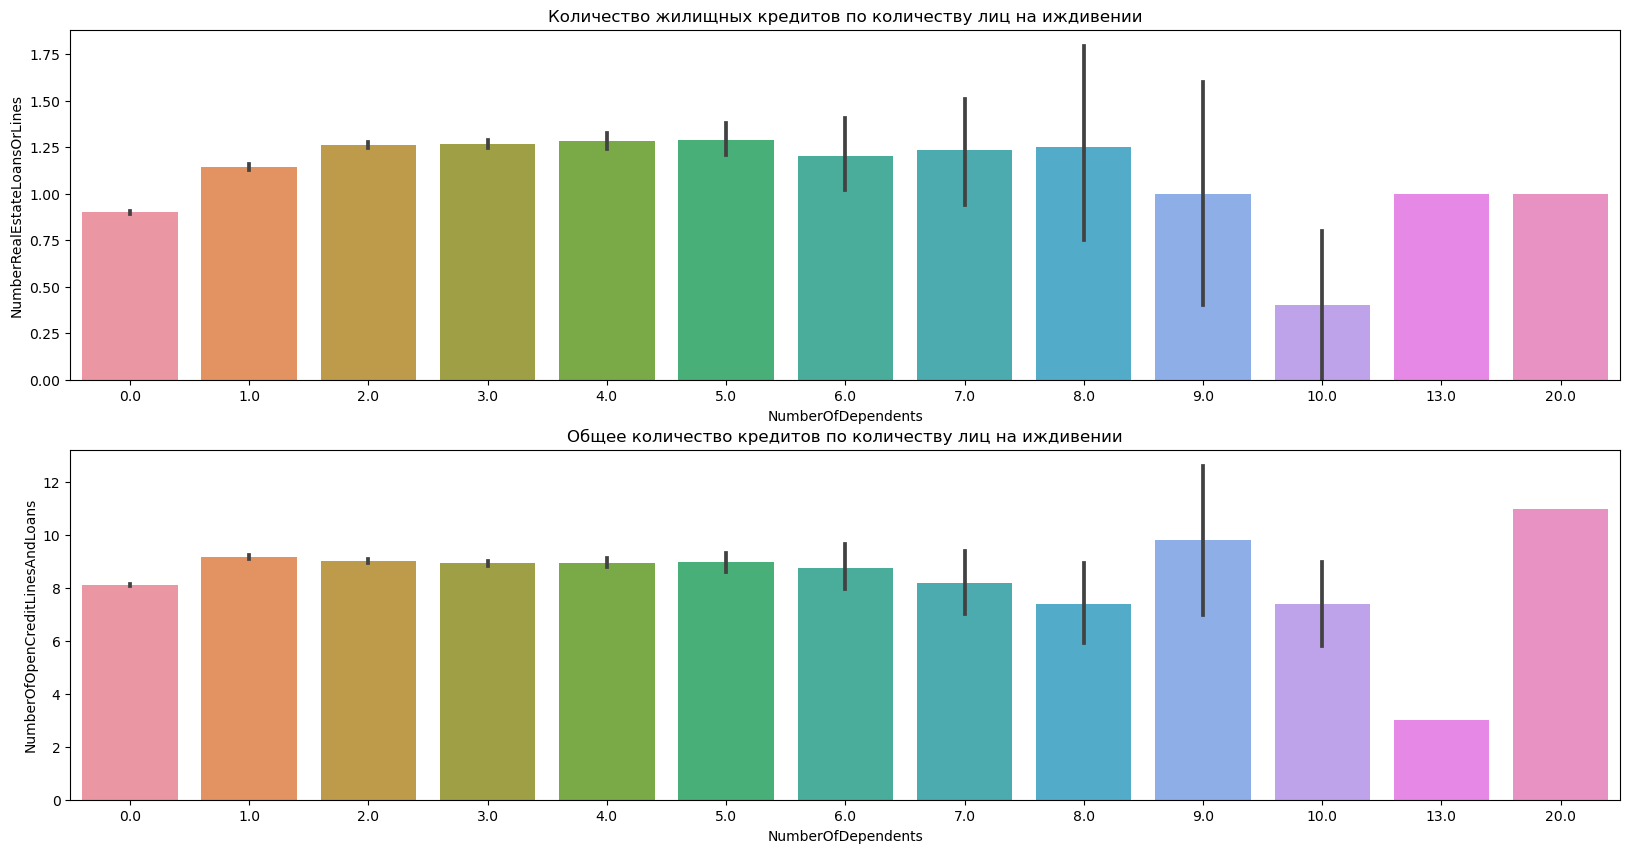

In [30]:
plt.figure(figsize=(20,10))


plt.subplot (2,1,1)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberRealEstateLoansOrLines');
plt.title ('Количество жилищных кредитов по количеству лиц на иждивении');

plt.subplot (2,1,2)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberOfOpenCreditLinesAndLoans');
plt.title ('Общее количество кредитов по количеству лиц на иждивении');

#### Вывод: у лиц без или с 9 иждивенцами и более меньше всего кредитов на жилье. А у лиц с 9 и 20 иждивенцами больше всего других кредитов.

#### 02. Оценим количество просрочек в зависимости от числа лиц на иждивении после разбития на группы

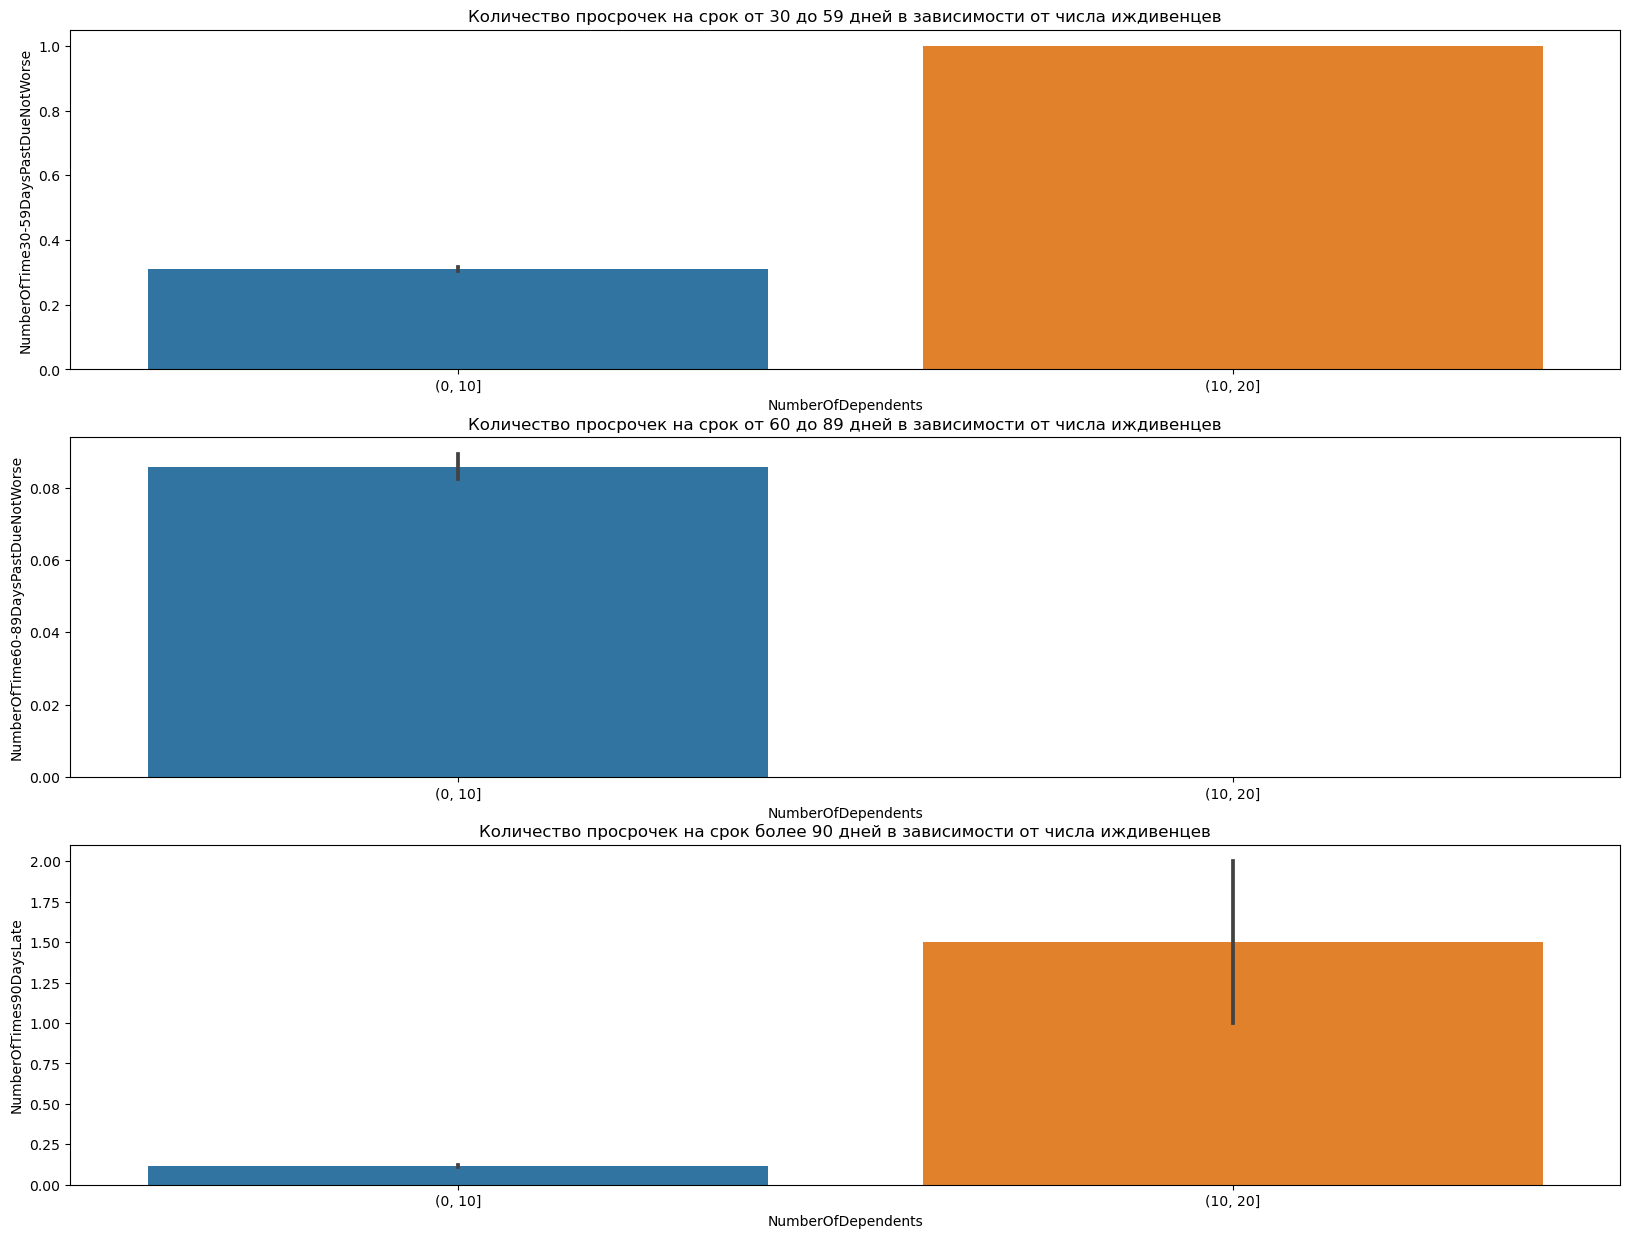

In [31]:
plt.figure(figsize=(20,15))

binned_val = pd.cut(df.NumberOfDependents, 
                   bins = [0,10,20])

plt.subplot (3,1,1)
sns.barplot(data=df, x=binned_val, y='NumberOfTime30-59DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 30 до 59 дней в зависимости от числа иждивенцев');


plt.subplot (3,1,2)
sns.barplot(data=df, x=binned_val, y='NumberOfTime60-89DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 60 до 89 дней в зависимости от числа иждивенцев');

plt.subplot (3,1,3)
sns.barplot(data=df, x=binned_val, y='NumberOfTimes90DaysLate')
plt.title ('Количество просрочек на срок более 90 дней в зависимости от числа иждивенцев');

##### Итог: Исходя из представленных графиков я бы разбил все случаи на 2 группы: 0-10 - Группа 1, 11-20 - Группа 2

In [32]:
df.loc[(df.NumberOfDependents>=0) & (df.NumberOfDependents<=10), 'BinNumberOfDependents']=1
df.loc[(df.NumberOfDependents>=11), 'BinNumberOfDependents']=2

#### 03. Оценим общее количество открытых кредитных линий общих и по недвижимости

<AxesSubplot: xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

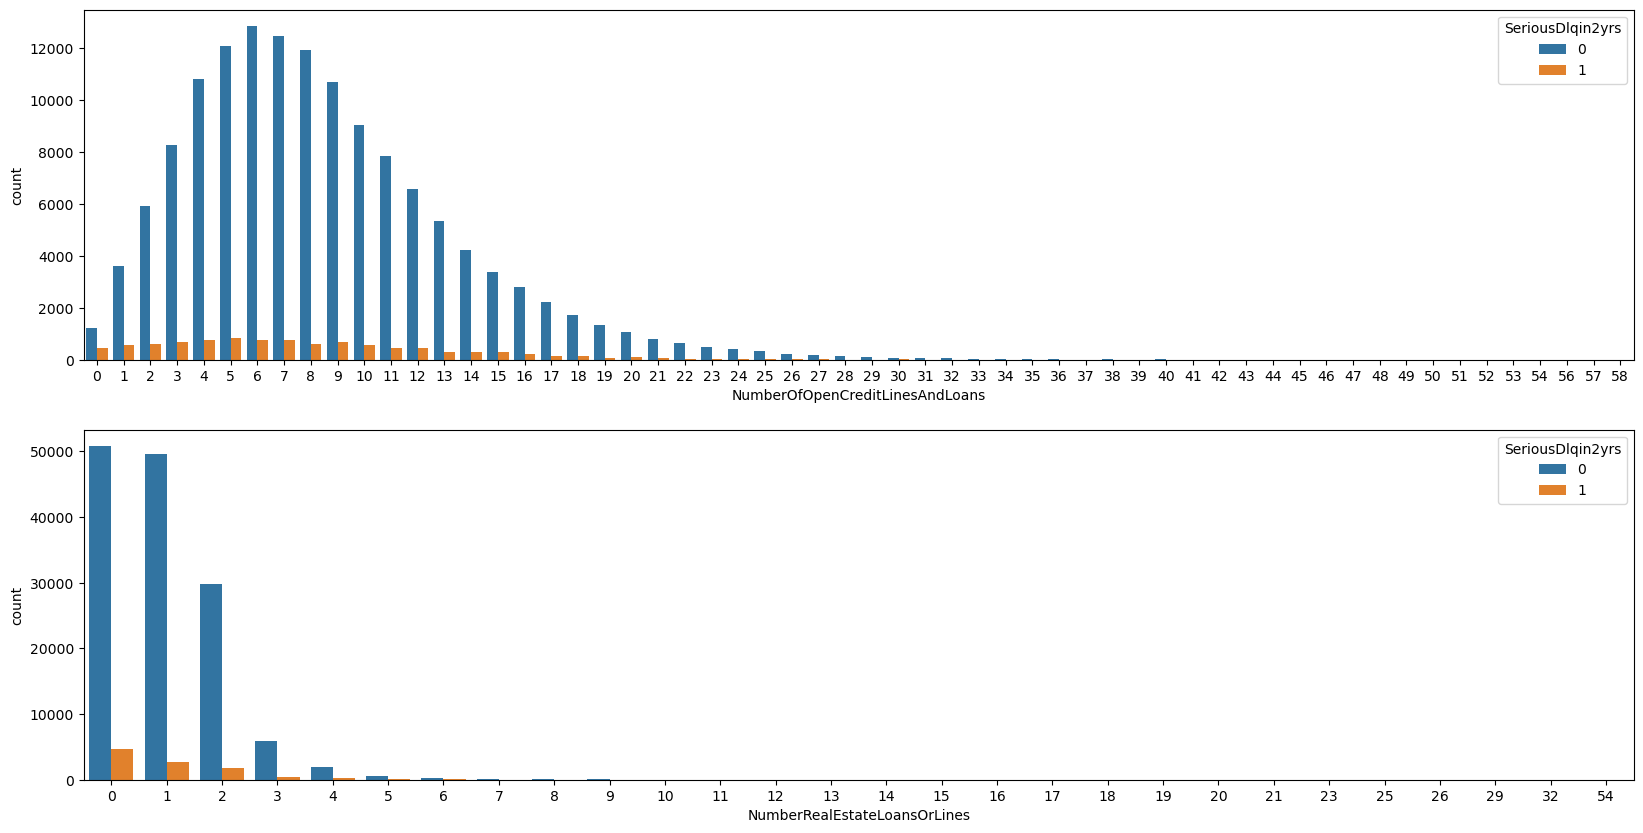

In [33]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['NumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['NumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

#### Итог: Исходя из представленных графиков я бы разбил общие кредиты на промежутки: 0-12 - Группа 1, 13-20 - Группа 2, 21 и более - Группа 3.

#### Кредиты на жилье на: 0-2 - Группа 1, 3 и более - Группа 2

In [34]:
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=0) & (df.NumberOfOpenCreditLinesAndLoans<=12), 'BinNumberOfOpenCreditLinesAndLoans']=1
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=13) & (df.NumberOfOpenCreditLinesAndLoans<=20), 'BinNumberOfOpenCreditLinesAndLoans']=2
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=21), 'BinNumberOfOpenCreditLinesAndLoans']=3

In [35]:
df.loc[(df.NumberRealEstateLoansOrLines>=0) & (df.NumberRealEstateLoansOrLines<=2), 'BinNumberRealEstateLoansOrLines']=1
df.loc[(df.NumberRealEstateLoansOrLines>=3), 'BinNumberRealEstateLoansOrLines']=2

<AxesSubplot: xlabel='BinNumberRealEstateLoansOrLines', ylabel='count'>

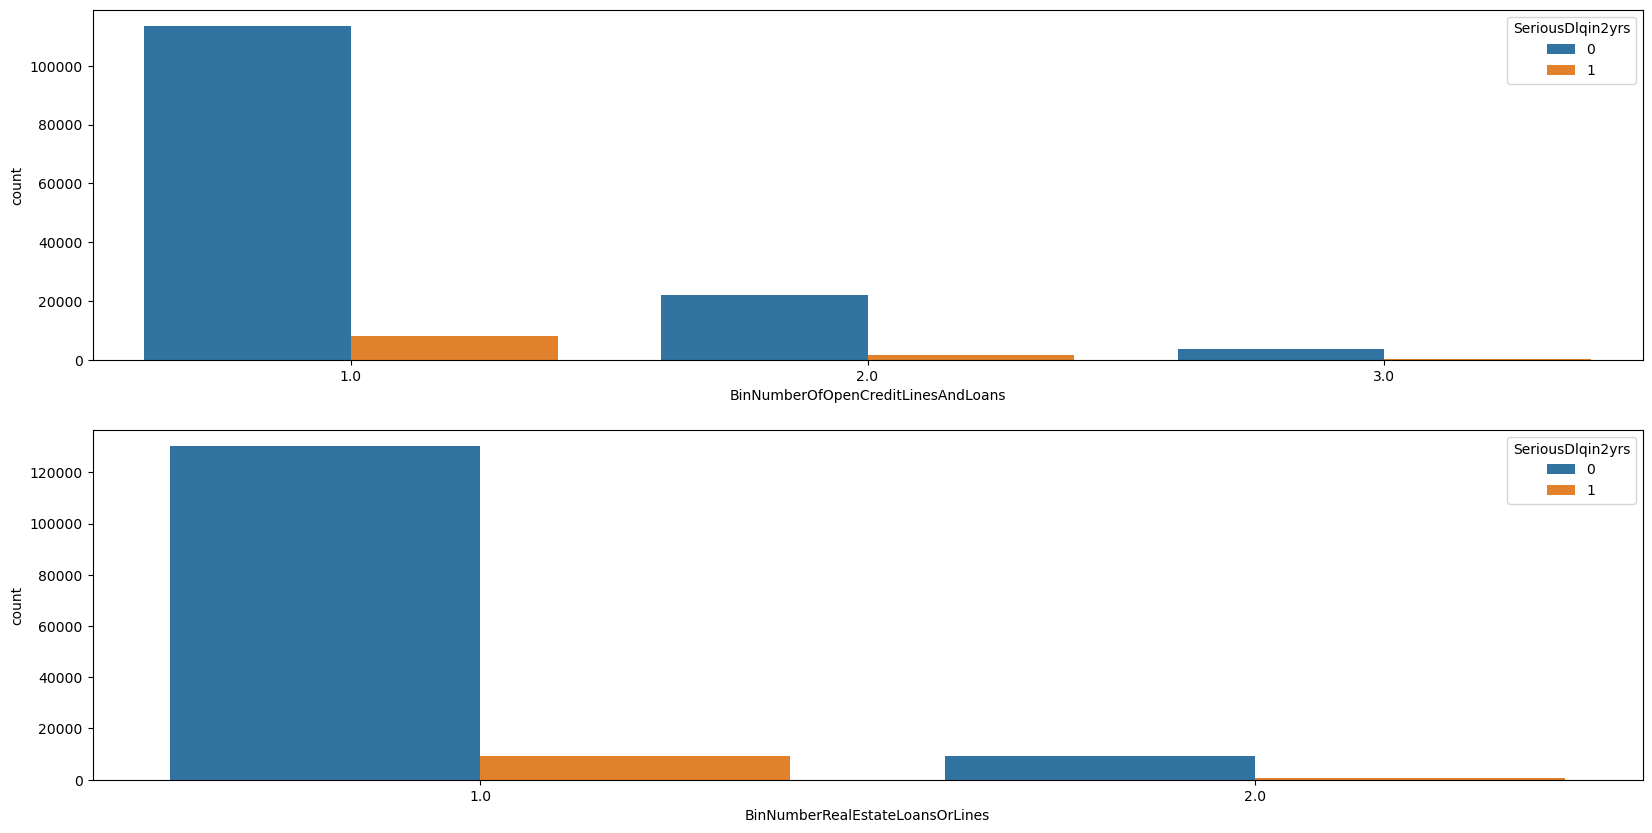

In [36]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['BinNumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['BinNumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

### IV. Обучение

### IV.1 Формируем наборы

In [37]:
#df_scaled = pd.DataFrame(MM.fit_transform(df), columns=df.columns)

In [38]:
#,'NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'
X=df.drop(['SeriousDlqin2yrs'],axis=1)
y=df['SeriousDlqin2yrs']

In [39]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.3)

In [40]:
X_train = MM.fit_transform(X_train)
X_val = MM.fit_transform(X_val)
X_test = MM.fit_transform(X_test)

In [41]:
X_train

array([[2.36712722e-06, 2.72727273e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.17510570e-07, 5.22727273e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.97601877e-05, 3.97727273e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.97207521e-05, 1.25000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.67980256e-06, 6.47727273e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.69906082e-05, 4.31818182e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### IV.2 Создаем загрузчик

In [42]:
class MyDataset(Dataset):
    def __init__(self, X,y):
        self.x_train=torch.tensor(X,dtype=torch.float32)
        self.y_train=torch.tensor(y.values,dtype=torch.float32)
 
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [43]:
train_set=MyDataset(X_train, y_train)
test_set=MyDataset(X_test, y_test)
val_set=MyDataset(X_val, y_val)

In [44]:
train_loader=DataLoader(train_set,batch_size=32,shuffle=True)
test_loader=DataLoader(test_set,batch_size=32,shuffle=True)
val_loader=DataLoader(val_set,batch_size=32,shuffle=True)

### IV.3 Формируем нейронную сеть

In [46]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(13, 2000)
        self.fc2 = nn.Linear(2000,500)
        self.fc3 = nn.Linear(500,1)
        
        self.relu = ReLU()
        self.batchnorm = BatchNorm1d(2000)
        
    def forward(self, x):
        
        x = self.relu(self.fc1(x))
        x = self.batchnorm(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [47]:
simplenet = SimpleNet()

In [48]:
optimizer = optim.SGD(simplenet.parameters(), lr=0.00001)

In [49]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=13, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

##### IV.4 Пишем функцию обучения

In [50]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [51]:
def plt_acc_loss(train, val, epochs, label):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training ' + label)
    plt.title('Training ' + label)
    
    plt.plot(epochstoplot, val, label='Validation ' + label)
    plt.title('Validation ' + label)
    
    plt.xlabel('Epochs')
    plt.ylabel(label)
    
    plt.legend()
    plt.show()

In [52]:
Val_acc = []
Train_acc = []
Val_loss = []
Train_loss = []

In [53]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        val_acc = 0.0
        train_acc = 0.0
        
        print('Epoch: {}'.format(epoch))
        
        model.train()
        for batch in tqdm(train_loader, desc = 'Training set'):
            
            optimizer.zero_grad()
            
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            output = model(inputs)
            loss = loss_fn(output, targets.unsqueeze(1))
            
            acc = binary_acc(output, targets.unsqueeze(1))
            train_acc += acc.item() 
            
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
        training_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        model.eval()
        for batch in tqdm(val_loader,  desc = 'Validation set'):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets.unsqueeze(1)) 
            valid_loss += loss.item()
            
            acc = binary_acc(output, targets.unsqueeze(1))
            val_acc += acc.item() 
            
        valid_loss /= len(val_loader)
        val_acc/=len(val_loader)
        
        Val_acc.append(val_acc)
        Train_acc.append (train_acc)
        Val_loss.append (valid_loss)
        Train_loss.append (training_loss)
   
        print('Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(training_loss, valid_loss))
        print('Training Acc: {:.4f}, Validation Acc: {:.4f}'.format(train_acc, val_acc))

### IV.6 Обучаем модель

In [54]:
train(simplenet, optimizer,torch.nn.BCEWithLogitsLoss(), train_loader,val_loader, epochs=5, device=device)

Epoch: 1


Validation set: 100%|██████████| 980/980 [00:01<00:00, 626.38it/s]


Training Loss: 0.6345, Validation Loss: 0.5726
Training Acc: 82.6273, Validation Acc: 93.5337
Epoch: 2


Validation set: 100%|██████████| 980/980 [00:01<00:00, 575.36it/s]


Training Loss: 0.5258, Validation Loss: 0.4856
Training Acc: 93.4677, Validation Acc: 93.5449
Epoch: 3


Validation set: 100%|██████████| 980/980 [00:01<00:00, 626.23it/s]


Training Loss: 0.4543, Validation Loss: 0.4328
Training Acc: 93.5014, Validation Acc: 93.5602
Epoch: 4


Validation set: 100%|██████████| 980/980 [00:01<00:00, 594.09it/s]


Training Loss: 0.4042, Validation Loss: 0.3870
Training Acc: 93.4977, Validation Acc: 93.5449
Epoch: 5


Validation set: 100%|██████████| 980/980 [00:01<00:00, 590.63it/s]

Training Loss: 0.3674, Validation Loss: 0.3533
Training Acc: 93.4943, Validation Acc: 93.5551


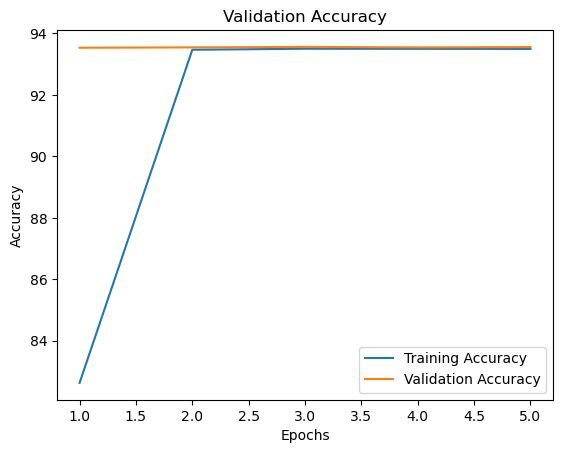

In [55]:
plt_acc_loss(Train_acc, Val_acc, 5, 'Accuracy')

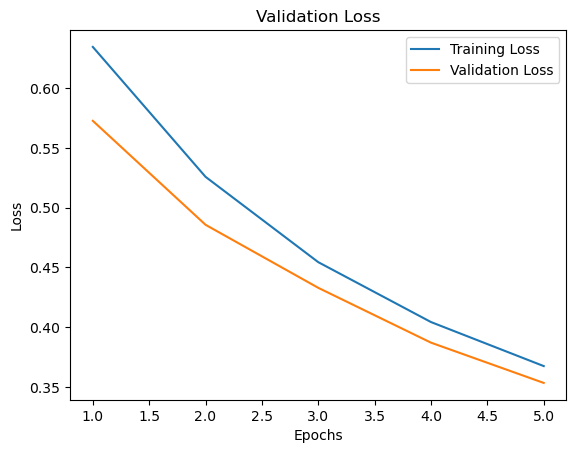

In [56]:
plt_acc_loss(Train_loss, Val_loss, 5, 'Loss')

### IV.6 Проверяем на тестовом наборе

In [57]:
test_acc = 0.0
test_loss = 0.0

model = simplenet.eval()
loss_fn = torch.nn.BCEWithLogitsLoss()

for batch in tqdm(test_loader,  desc = 'Test set'):
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output, targets.unsqueeze(1)) 
    
    test_loss += loss.item()
    
    acc = binary_acc(output, targets.unsqueeze(1))
    test_acc += acc.item()

test_loss /= len(test_loader)
test_acc/=len(test_loader)

print('Test Loss: {:.4f}, Test accuracy: {:.4f}'.format(test_loss, test_acc))

Test set: 100%|██████████| 420/420 [00:00<00:00, 537.27it/s]

Test Loss: 0.3520, Test accuracy: 93.4667
